<a href="https://colab.research.google.com/github/abigailcruz29/projeto-cnn-unidade-10/blob/main/Unidade_10_Rede_Convulacional_Grupo_32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importação das Bibliocatecas

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from typing import List, Tuple
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, roc_curve, auc, classification_report, confusion_matrix

## Carregamento do Dataset

In [ ]:
!pip install kaggle
!kaggle datasets download -d arbazkhan971/cuhk-face-sketch-database-cufs --force
!unzip -oq "cuhk-face-sketch-database-cufs.zip"

def listar_arquivos_na_pasta(caminho_pasta: str) -> List[str]:
    """
    Lista todos os arquivos em uma pasta específica.

    Parâmetros:
    caminho_pasta (str): Caminho absoluto ou relativo da pasta a ser listada.

    Retorno:
    List[str]: Lista com os nomes dos arquivos presentes na pasta. Se a pasta não existir, retorna uma lista vazia.

    Exceções:
    Se a pasta não for encontrada, uma mensagem de erro será registrada, e uma lista vazia será retornada.
    """
    try:
        # Verifica se o caminho fornecido é uma pasta
        if not os.path.isdir(caminho_pasta):
            raise NotADirectoryError(f"O caminho fornecido não é uma pasta: {caminho_pasta}")

        # Retorna a lista de arquivos na pasta
        return os.listdir(caminho_pasta)

    except FileNotFoundError:
        print(f"Erro: Pasta não encontrada em {caminho_pasta}.")
        return []

    except NotADirectoryError as e:
        print(f"Erro: {e}")
        return []

    except PermissionError:
        print(f"Erro: Permissão negada para acessar a pasta {caminho_pasta}.")
        return []

    except Exception as e:
        print(f"Erro inesperado: {e}")
        return []

Dataset URL: https://www.kaggle.com/datasets/arbazkhan971/cuhk-face-sketch-database-cufs
License(s): copyright-authors
 77% 87.0M/113M [00:00<00:00, 248MB/s]
100% 113M/113M [00:00<00:00, 237MB/s] 


## Listagem das Imagens

In [ ]:
def contar_imagens(caminho_pasta: str) -> int:
    """
    Conta o número de arquivos de imagem em uma pasta específica.

    Parâmetros:
    caminho_pasta (str): Caminho absoluto ou relativo da pasta a ser verificada.

    Retorno:
    int: Quantidade total de arquivos de imagem encontrados na pasta. Retorna 0 se não houver imagens ou se a pasta não for encontrada.

    Exceções:
    Se a pasta não for encontrada ou se houver erro, uma mensagem de erro será registrada e o retorno será 0.
    """
    # Extensões válidas de arquivos de imagem
    extensoes_imagem = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}

    try:
        # Verifica se o caminho fornecido é uma pasta
        if not os.path.isdir(caminho_pasta):
            raise NotADirectoryError(f"O caminho fornecido não é uma pasta: {caminho_pasta}")

        # Lista todos os arquivos na pasta
        arquivos = os.listdir(caminho_pasta)

        # Conta os arquivos de imagem com base na extensão
        arquivos_imagem = [
            f for f in arquivos
            if os.path.isfile(os.path.join(caminho_pasta, f)) and
            any(f.lower().endswith(ext) for ext in extensoes_imagem)
        ]

        # Retorna a quantidade de arquivos de imagem
        return len(arquivos_imagem)

    except FileNotFoundError:
        print(f"Erro: Pasta não encontrada em {caminho_pasta}.")
        return 0

    except NotADirectoryError as e:
        print(f"Erro: {e}")
        return 0

    except PermissionError:
        print(f"Erro: Permissão negada para acessar a pasta {caminho_pasta}.")
        return 0

    except Exception as e:
        print(f"Erro inesperado: {e}")
        return 0

# Exemplo de uso
pasta_fotos = "photos"
quantidade_imagens = contar_imagens(pasta_fotos)
print(f"Número de imagens na pasta '{pasta_fotos}': {quantidade_imagens}")

Número de imagens na pasta 'photos': 188


## Redimensionamento e Normalização das Imagens

In [ ]:
def redimensionar_e_normalizar_imagem(caminho_imagem: str, tamanho: Tuple[int, int] = (200, 250)) -> np.ndarray:
    """
    Redimensiona a imagem para o tamanho especificado e normaliza seus valores RGB para o intervalo [0, 1].

    Parâmetros:
    caminho_imagem (str): Caminho da imagem a ser processada.
    tamanho (tuple): Novo tamanho (largura, altura) da imagem. O padrão é (200, 250).

    Retorno:
    np.ndarray: A imagem redimensionada e normalizada como um array numpy.
    """
    try:
        # Abrir a imagem
        img = Image.open(caminho_imagem)

        # Redimensionar para o tamanho desejado (largura, altura)
        img_resized = img.resize(tamanho)

        # Normalizar os valores RGB para o intervalo [0, 1]
        img_array = np.array(img_resized) / 255.0

        return img_array

    except Exception as e:
        print(f"Erro ao processar a imagem '{caminho_imagem}': {e}")
        return np.array([])

def rotular_imagem(nome_imagem: str) -> int:
    """
    Gera o rótulo para a imagem com base no nome do arquivo.
    Assume que nomes que começam com 'm' ou 'm1' são masculinos (rótulo 0),
    e nomes que começam com 'f' ou 'f1' são femininos (rótulo 1).

    Parâmetros:
    nome_imagem (str): Nome do arquivo de imagem a ser rotulado.

    Retorno:
    int: Rótulo da imagem (0 para masculino, 1 para feminino).
    """
    # Gerar rótulo com base no nome da imagem
    if nome_imagem.lower().startswith(("m", "m1")):
        return 0  # Masculino
    elif nome_imagem.lower().startswith(("f", "f1")):
        return 1  # Feminino
    else:
        print(f"Atenção: Nome do arquivo '{nome_imagem}' não segue o padrão esperado.")
        return -1  # Indicativo de erro

## Processamento das Imagens

In [ ]:
def processar_imagens(caminho_pasta: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Processa as imagens de uma pasta específica, ajustando suas dimensões e normalizando os valores RGB.
    Também gera os rótulos de classe com base no nome do arquivo.

    Parâmetros:
    caminho_pasta (str): Caminho da pasta onde as imagens estão localizadas.

    Retorno:
    Tuple[np.ndarray, np.ndarray]: Dupla contendo:
        - Um array numpy com as imagens processadas.
        - Um array numpy com os rótulos correspondentes (0 para masculino, 1 para feminino).
    """
    # Extensões válidas de arquivos de imagem
    extensoes_validas = {".jpg", ".jpeg", ".png", ".bmp", ".gif"}

    # Listas para armazenar as imagens e rótulos
    imagens = []
    rotulos = []

    # Contadores para as classes
    masculino = 0
    feminino = 0

    try:
        # Verificar se a pasta existe
        if not os.path.isdir(caminho_pasta):
            raise NotADirectoryError(f"O caminho fornecido não é um diretório válido: {caminho_pasta}")

        # Listar os arquivos na pasta e filtrar apenas as imagens válidas
        lista_arquivos = os.listdir(caminho_pasta)
        arquivos_imagens = [
            f for f in lista_arquivos if os.path.splitext(f)[1].lower() in extensoes_validas
        ]

        # Iteração sobre os arquivos de imagem
        for imagem in arquivos_imagens:
            # Caminho completo da imagem
            caminho_imagem = os.path.join(caminho_pasta, imagem)

            # Processar a imagem (redimensionamento e normalização)
            img_array = redimensionar_e_normalizar_imagem(caminho_imagem)

            # Verificar se a imagem foi processada corretamente
            if img_array.size > 0:
                # Adicionar a imagem processada à lista
                imagens.append(img_array)

                # Gerar rótulo com base no nome do arquivo
                rotulo = rotular_imagem(imagem)

                if rotulo != -1:
                    rotulos.append(rotulo)
                    if rotulo == 0:
                        masculino += 1
                    elif rotulo == 1:
                        feminino += 1

        # Exibir contagem de imagens rotuladas
        print(f"Imagens rotuladas como Masculinas: {masculino}")
        print(f"Imagens rotuladas como Femininas: {feminino}")

        # Retornar as imagens e rótulos como arrays numpy
        return np.array(imagens), np.array(rotulos)

    except FileNotFoundError:
        print(f"Erro: Pasta não encontrada no caminho {caminho_pasta}")
        return np.array([]), np.array([])

    except NotADirectoryError as e:
        print(f"Erro: {e}")
        return np.array([]), np.array([])

    except Exception as e:
        print(f"Erro inesperado: {e}")
        return np.array([]), np.array([])

pasta_fotos = "photos"
imagens, rotulos_classes = processar_imagens(pasta_fotos)

Imagens rotuladas como Masculinas: 134
Imagens rotuladas como Femininas: 54


#### **Interpretação:** O desequilíbrio no número de imagens entre as duas classes (Masculino e Feminino) é um aspecto importante a ser considerado no treinamento de um modelo baseado em redes neurais convolucionais (CNN). A seguir, apresento uma interpretação detalhada:

#### **1. Distribuição dos Dados**
* **Classe Masculino (134 imagens):** Representa aproximadamente 71% do total de imagens.
* **Classe Feminino (54 imagens):** Representa cerca de 29% do total de imagens.

####Esse desbalanceamento significa que o modelo pode ser mais exposto a exemplos da classe Masculino durante o treinamento, o que pode levá-lo a ter um viés em favor dessa classe.

#### **2. Impacto no Treinamento**
* **Possível Viés no Modelo:** A CNN pode aprender a classificar mais frequentemente como Masculino, já que essa classe domina o dataset. Isso pode resultar em alta precisão para Masculino, mas baixa para Feminino.

* **Desempenho Métrico Desequilibrado:** Métricas como acurácia podem ser enganadoras nesse cenário. Por exemplo, um modelo que classifica tudo como Masculino ainda teria 71% de acurácia, mas seu desempenho real seria pobre para Feminino.

## Divisão do Dataset

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
from typing import Tuple

def dividir_dataset(imagens: np.ndarray, rotulos: np.ndarray, seed: int = 23) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Divide o dataset em três partes: treino (50%), validação (30%) e teste (20%),
    com base nas proporções fornecidas e utilizando uma semente fixa para garantir a reprodutibilidade.

    Parâmetros:
    imagens (np.ndarray): Array com as imagens processadas.
    rotulos (np.ndarray): Array com os rótulos das imagens.
    seed (int): Valor da semente para garantir a reprodutibilidade.

    Retorno:
    Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        - X_train: Conjunto de imagens de treinamento.
        - X_val: Conjunto de imagens de validação.
        - X_test: Conjunto de imagens de teste.
        - y_train: Rótulos de treinamento.
        - y_val: Rótulos de validação.
        - y_test: Rótulos de teste.
    """
    # Validações básicas
    if len(imagens) != len(rotulos):
        raise ValueError("O número de imagens e rótulos deve ser igual.")

    if len(imagens) == 0:
        raise ValueError("O dataset não pode estar vazio.")

    # Divisão do dataset em treino + validação (80%) e teste (20%)
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        imagens, rotulos, test_size=0.2, random_state=seed, stratify=rotulos
    )

    # Divisão do conjunto de treino + validação em treino (50%) e validação (30%) do total
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.3, random_state=seed, stratify=y_train_val
    )

    # Verificação final das divisões
    assert len(X_train) + len(X_val) + len(X_test) == len(imagens), "Erro na divisão dos dados."
    assert len(y_train) + len(y_val) + len(y_test) == len(rotulos), "Erro na divisão dos rótulos."

    return X_train, X_val, X_test, y_train, y_val, y_test

# Exemplo de uso
imagens = np.array(imagens)  # Certifique-se de que as imagens estão no formato numpy array
rotulos_classes = np.array(rotulos_classes)  # Certifique-se de que os rótulos estão no formato numpy array

# Dividindo o dataset
X_train, X_val, X_test, y_train, y_val, y_test = dividir_dataset(imagens, rotulos_classes)

# Exibição dos resultados
print(f"Conjunto de treinamento: {X_train.shape}, {y_train.shape}")
print(f"Conjunto de validação: {X_val.shape}, {y_val.shape}")
print(f"Conjunto de teste: {X_test.shape}, {y_test.shape}")

Conjunto de treinamento: (105, 250, 200, 3), (105,)
Conjunto de validação: (45, 250, 200, 3), (45,)
Conjunto de teste: (38, 250, 200, 3), (38,)


#### **Interpretação:**
**1. Conjunto de Treinamento:**
* **Formato das imagens(105, 250, 200, 3):** Isso significa que há 105 imagens no conjunto de treinamento, cada uma com dimensão 250x200 pixels e 3 canais de cores (imagens RGB).
* **Formato dos rótulos(105,):** Há 105 rótulos correspondentes, indicando a classe de cada imagem.

**2. Conjunto de Validação:**
* **Formato das imagens(45, 250, 200, 3):** O conjunto de validação possui 45 imagens, com as mesmas dimensões e características do conjunto de treinamento.
* **Formato dos rótulos(45,):** Há 45 rótulos associados às imagens de validação.

**3. Conjunto de Teste:**
* **Formato das imagens(38, 250, 200, 3):** Este conjunto contém 38 imagens, também com as dimensões e canais especificados.
* **Formato dos rótulos(38,):** Há 38 rótulos correspondentes às imagens do conjunto de teste.

#### **Distribuição Proporcional:**
* **Total de amostras:** 105 + 45 + 38 = 188, que é o total inicial de imagens.

## Modelo CNN

In [ ]:
def criar_modelo_cnn(input_shape: tuple) -> models.Sequential:
    """
    Cria um modelo de rede neural convolucional (CNN) baseado em uma arquitetura personalizada.

    Parâmetros:
    input_shape (tuple): Forma das imagens de entrada, por exemplo (250, 200, 3).

    Retorno:
    model: Modelo Keras com arquitetura CNN.
    """
    model = models.Sequential()

    # Camada convolucional 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Camada convolucional 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Camada convolucional 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten para converter a matriz 2D em um vetor 1D
    model.add(layers.Flatten())

    # Camada totalmente conectada (densa)
    model.add(layers.Dense(128, activation='relu'))

    # Camada de Dropout para regularização
    model.add(layers.Dropout(0.5))

    # Camada de saída
    model.add(layers.Dense(2, activation='softmax'))  # 2 classes (masculino, feminino)

    return model

# Definindo o modelo
input_shape = (250, 200, 3)  # Imagens de 250x200 com 3 canais (RGB)
modelo = criar_modelo_cnn(input_shape)

# Compilando o modelo
modelo.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',  # Usando cross-entropy para classificação multi-classe
               metrics=['accuracy'])

# Resumo do modelo
modelo.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 248, 198, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 124, 99, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 122, 97, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 61, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 59, 46, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 29, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 85376)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │      10,928,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,021,762 (42.04 MB)

 Trainable params: 11,021,762 (42.04 MB)

 Non-trainable params: 0 (0.00 B)

#### **Interpretação:**

**1. Camada Conv2D (conv2d_12):**
* **Tipo:** Camada convolucional com 32 filtros (kernels) de tamanho 3x3.
* **Saída:** A forma das imagens de entrada diminui para (248, 198, 32), com 32 canais de características extraídos pela convolução.
* **Parâmetros:** 896 (filtros * (tamanho do kernel) + bias).

**2. Camada MaxPooling2D (max_pooling2d_12):**
* **Tipo:** Camada de pooling máximo com uma janela de 2x2.
* **Saída:** Reduz a resolução espacial para (124, 99, 32), mantendo a profundidade dos 32 filtros.
* **Parâmetros:** 0 (não há parâmetros treináveis aqui).

**3. Camada Conv2D (conv2d_13):**
* **Tipo:** Camada convolucional com 64 filtros de tamanho 3x3.
* **Saída:** A forma da imagem é reduzida para (122, 97, 64).
* **Parâmetros:** 18.496 (filtros * (tamanho do kernel) + bias).

**4. Camada MaxPooling2D (max_pooling2d_13):**
* **Tipo:** Camada de pooling máximo com uma janela de 2x2.
* **Saída:** A resolução espacial é reduzida para (61, 48, 64).
* **Parâmetros:** 0.

**5. Camada Conv2D (conv2d_14):**
* **Tipo:** Camada convolucional com 128 filtros de tamanho 3x3.
* **Saída:** A forma da imagem é reduzida para (59, 46, 128).
* **Parâmetros:** 73.856 (filtros * (tamanho do kernel) + bias).

**6. Camada MaxPooling2D (max_pooling2d_14):**
* **Tipo:** Camada de pooling máximo com uma janela de 2x2.
* **Saída:** A resolução espacial é reduzida para (29, 23, 128).
* **Parâmetros:** 0.

**7. Camada Flatten (flatten_4):**
* **Tipo:** Camada de flattening, que transforma a saída 3D da camada anterior em um vetor 1D.
* **Saída:** (85376), o que representa a totalidade dos elementos da matriz 3D.
* **Parâmetros:** 0.

**8. Camada Densa (dense_8):**
* **Tipo:** Camada totalmente conectada com 128 neurônios e ativação ReLU.
* **Saída:** (128).
* **Parâmetros:** 10.928.256 (neurônios * entradas da camada anterior + bias).

**9. Camada Dropout (dropout_4):**
* **Tipo:** Camada de dropout com taxa de 0,5, para regularização (evitar overfitting).
* **Saída:** (128).
* **Parâmetros:** 0.

**10. Camada Densa (dense_9):**
* **Tipo:** Camada totalmente conectada com 2 neurônios (para as 2 classes: masculino e feminino) e ativação softmax.
* **Saída:** (2).
* **Parâmetros:** 258 (neurônios * entradas da camada anterior + bias).

## Compilação e Treinamento:

In [ ]:
# Treinamento do modelo
historico = modelo.fit(X_train, y_train, epochs=12, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.6296 - loss: 1.9582 - val_accuracy: 0.7111 - val_loss: 1.0126
Epoch 2/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.6948 - loss: 0.9475 - val_accuracy: 0.8000 - val_loss: 0.5948
Epoch 3/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - accuracy: 0.8519 - loss: 0.5407 - val_accuracy: 0.8444 - val_loss: 0.4628
Epoch 4/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.8782 - loss: 0.4075 - val_accuracy: 0.8000 - val_loss: 0.4679
Epoch 5/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.8716 - loss: 0.3749 - val_accuracy: 0.8222 - val_loss: 0.4179
Epoch 6/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.9001 - loss: 0.2369 - val_accuracy: 0.8667 - val_loss: 0.4433
Epoch 7/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.8942 - loss: 0.2140 - val_accuracy: 0.8222 - val_loss: 0.4100
Epoch 8/12
4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.9372 - loss: 0.1808 - val_accuracy: 0.8444 - val_loss: 0.4358
Epoch 9/

## Métricas de Avaliação

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step
F1-Score: 0.7619
AUC-ROC: 0.9394


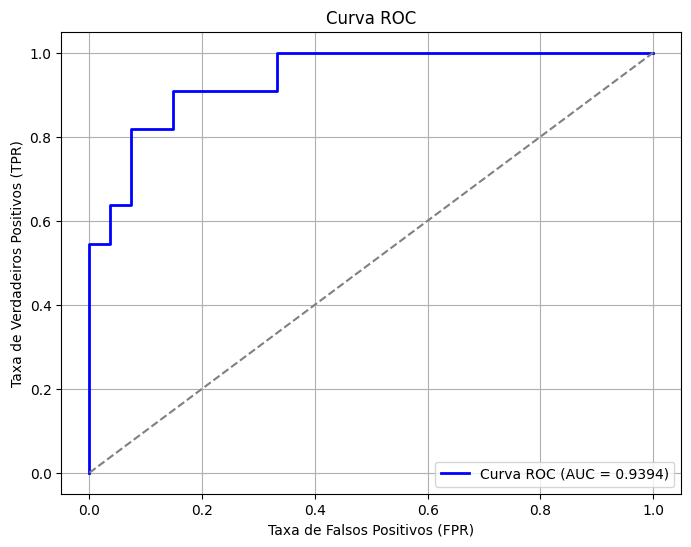

In [ ]:
# Previsões no conjunto de teste
y_pred = modelo.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Classes previstas (0 ou 1)

# Cálculo do F1-Score
f1 = f1_score(y_test, y_pred_classes)
print(f"F1-Score: {f1:.4f}")

# Cálculo da Curva ROC e AUC-ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1])  # Usamos a probabilidade para a classe '1'
roc_auc = auc(fpr, tpr)
print(f"AUC-ROC: {roc_auc:.4f}")

# Gráfico da Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### **Interpretação:**

**1. F1-Score(0.7619):** O F1-Score é uma métrica que combina a precisão e a sensibilidade (recall) em um único valor, sendo especialmente útil em situações onde há um desbalanceamento entre as classes. O valor de 0.7619 indica um bom equilíbrio entre precisão e recall, sugerindo que o modelo está fazendo uma classificação razoavelmente precisa e completa, sem muitos falsos positivos ou falsos negativos.

**2. AUC-ROC(0.9394):** O AUC-ROC (Area Under the Curve - Receiver Operating Characteristic) é uma medida da capacidade do modelo em distinguir entre as classes. O valor 0.9394 é considerado excelente, pois está muito próximo de 1, o que significa que o modelo tem uma alta capacidade de discriminação entre as classes, sendo eficaz em identificar corretamente as instâncias positivas e negativas. O AUC-ROC máximo é 1, o que indicaria um modelo perfeito.

**3. Gráfico da Curva ROC:** O gráfico da Curva ROC mostra a Taxa de Verdadeiros Positivos (TPR) em função da Taxa de Falsos Positivos (FPR) para diferentes limiares de decisão. A curva ROC é uma boa maneira de avaliar a performance do modelo para diferentes pontos de corte (thresholds).

* A curva azul representa a performance do modelo, com um AUC de 0.9394, que está bem afastado da linha diagonal (representada pela linha cinza tracejada), indicando que o modelo tem uma boa capacidade de classificação.
* A linha diagonal, linha de aleatoriedade, representa um modelo que faz previsões aleatórias. O fato de a curva estar longe dessa linha sugere que o modelo é significativamente melhor do que uma previsão aleatória.

#### **Conclusão**
Esses resultados indicam que o modelo tem um bom desempenho geral. O F1-Score de 0.7619 demonstra um bom equilíbrio entre a precisão e o recall, e a AUC-ROC de 0.9394 sugere uma excelente capacidade de discriminação entre as classes. O gráfico reforça esses achados, mostrando que o modelo não está apenas se saindo bem em um único ponto de corte, mas mantém uma boa performance geral em diferentes limiares.

## Gráfico da Matriz de Confusão

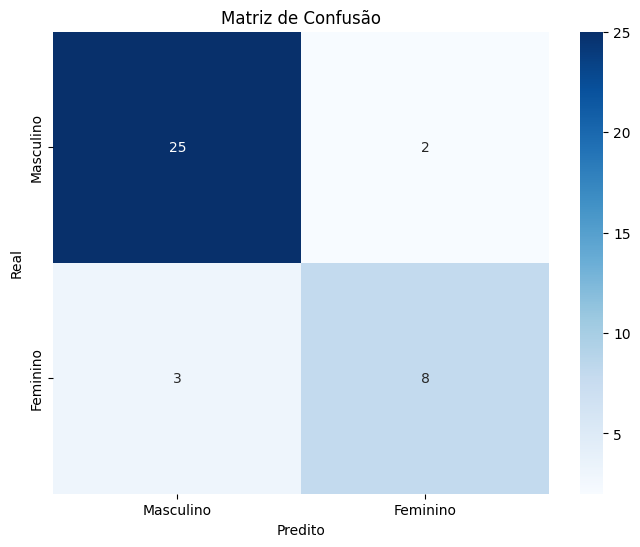

In [ ]:
def plotar_matriz_de_confusao(y_true, y_pred, labels):
    """
    Plota a matriz de confusão.

    Parâmetros:
    y_true (array-like): Rótulos reais.
    y_pred (array-like): Rótulos previstos pelo modelo.
    labels (list): Lista com os nomes das classes.
    """
    matriz_confusao = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matriz_confusao, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title("Matriz de Confusão")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

# Exemplo de uso:
labels = ["Masculino", "Feminino"]
plotar_matriz_de_confusao(y_test, y_pred_classes, labels)

#### **Interpretação da Matriz de Confusão:**

* **Primeira linha (classe real "Masculino"):**
 * **25:** O modelo previu corretamente como Masculino para 25 casos.
 * **2:** O modelo classificou erroneamente 2 casos como Feminino, quando na verdade eram Masculinos.

* **Segunda linha (classe real "Feminino"):**
 * **3:** O modelo classificou erroneamente 3 casos como Masculino, quando na verdade eram Femininos.
 * **8:** O modelo previu corretamente como Feminino para 8 casos.

#### **Conclusão**

#### A precisão para Masculino é ligeiramente mais alta do que para Feminino, o que pode indicar que o modelo tem um pequeno viés para classificar mais casos como Masculino. Essas informações podem ser úteis para ajustar o modelo, caso seja necessário, para melhorar a classificação da classe Feminino sem sacrificar demais a performance geral.

## Imagens Classificadas Incorretamente


Imagens classificadas incorretamente para a classe 'Masculino':


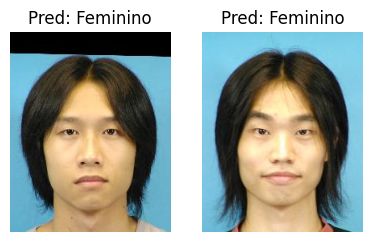


Imagens classificadas incorretamente para a classe 'Feminino':


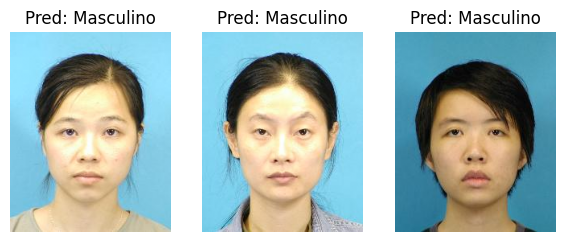

In [ ]:
def exibir_imagens_classificacao_incorreta(imagens, y_true, y_pred, classes, max_por_classe=5):
    """
    Exibe as imagens classificadas incorretamente, separadas por classe.

    Parâmetros:
    imagens (array-like): Conjunto de imagens.
    y_true (array-like): Rótulos reais.
    y_pred (array-like): Rótulos previstos.
    classes (list): Lista de classes ["Masculino", "Feminino"].
    max_por_classe (int): Número máximo de imagens a exibir por classe.
    """
    erros = [(img, pred, real) for img, pred, real in zip(imagens, y_pred, y_true) if pred != real]
    for classe_real in set(y_true):
        print(f"\nImagens classificadas incorretamente para a classe '{classes[classe_real]}':")
        erros_classe = [(img, pred) for img, pred, real in erros if real == classe_real]
        plt.figure(figsize=(12, 4))
        for i, (img, pred) in enumerate(erros_classe[:max_por_classe]):
            plt.subplot(1, max_por_classe, i + 1)
            plt.imshow(img, cmap="gray")
            plt.title(f"Pred: {classes[pred]}")
            plt.axis("off")
        plt.show()

# Exemplo de uso:
exibir_imagens_classificacao_incorreta(X_test, y_test, y_pred_classes, labels)

#### **Interpretação das Imagens Classificadas Incorretamente:**

**1. Imagens classificadas incorretamente para a classe 'Masculino' (2 imagens):**
Essas duas imagens foram rotuladas como "Masculino" no conjunto de teste, mas o modelo fez previsões erradas, classificando-as como "Feminino". Analisando isso, algumas questões podem ser levantadas:

* **Características Ambíguas:** As imagens podem ter características faciais ou de expressão que são difíceis de distinguir entre as duas classes. Se as imagens de "Masculino" possuem aspectos semelhantes aos das "Femininas", o modelo pode ter confundido.

* **Iluminação ou Qualidade da Imagem:** Diferenças na qualidade ou iluminação das imagens podem afetar a capacidade do modelo de identificar padrões faciais, causando uma classificação incorreta.

* **Ruído e Variabilidade:** Pequenas variações nas imagens (por exemplo, óculos, cabelos ou expressões faciais) podem causar confusão, já que essas variações podem ser características de ambas as classes e não apenas de uma.

**2. Imagens classificadas incorretamente para a classe 'Feminino' (3 imagens):**
Essas três imagens pertencem à classe "Feminino", mas o modelo fez previsões incorretas, classificando-as como "Masculino". Algumas razões possíveis para isso incluem:

* **Semelhanças entre Classes:** As imagens podem ter características que são comuns tanto em rostos masculinos quanto femininos, o que torna a classificação mais desafiadora. Isso pode ocorrer especialmente quando as características de gênero são menos pronunciadas, como em certos tipos de rosto ou estilo de cabelo.

* **Tendência do Modelo:** Como o dataset é desbalanceado, devido ao maior número de imagens masculinas do que imagens femininas. Por isso, o modelo aprendeu a classificar de forma tendenciosa para uma das classes, especialmente se a representação das classes no conjunto de treino não foi equilibrada.

* **Fatores Externos:** Questões como a pose da pessoa na imagem, o tipo de fundo ou outros elementos de distração podem afetar a performance do modelo. Um modelo de rede neural convolucional pode se distrair com essas características ao invés de focar nas características faciais mais relevantes.